<a href="https://colab.research.google.com/github/cergin07/Multilayer-Perceptron-Classify-on-Mnist-Digit-Classification/blob/main/Multilayer_Perceptron_Classify_on_Mnist_Digit_Classification_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Multilayer Perceptron Classify  on Mnist Digit Classification dataset

In this notebook,I will explain how can we use a multi layer perceptron to classify Mnist Digit  dataset.

The data set will be divided into 2 as 20 percent test set and 80 percent training set.

> Specifically for this problem , we are going to do the following:
> - Load the dataset
> - Preprocess the dataset
> - Build the model
> - Train the model
> - Predict data

**Before we build the models,we should talk about what multilayer perceptron is.**

MLP is consists of at least three layers of nodes: an input layer, a hidden layer and an output layer.

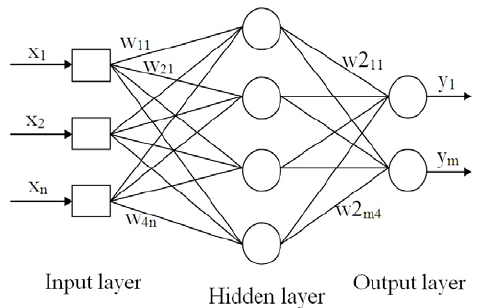



One neuron may not be enough for many inputs. The layer concept comes into play when more than one neuron performing parrallel processing is needed. As you can see, unlike the single perceptron model, there is atlest one hidden layer. The input layer receives the incomnig data and sends it to the middleware. Incoming information is transferred to the next layer. The number of intermediate layers varies according to the problem, at least one, and is adjusted according to the needs. 

**Input Layer:** It is the layer where the attributes of the sample that is wanted to be learned as input to a network are given as input. There should be as many input neurons as the number of attributes of the samples to be taught in the input layer.

**Output Layer:** It is the layer where the class information or label value or predicted real value of the samples in the artificial network is calculated as output.

**Hidden Layers:** These are the layers between the input layer and the output layers. The number of layers and the number of neurons on them can vary from problem to problem. Forward calculations and backward error propagation are performed in these layers.

Any mathematical function can be used as an activation function in the model. However, sigmoid, tang, linear, threshold and hard limiter functions are the most used functions.

 **What is Forward Propagation**

In the multilayer perceptron models, the journey starting from the input to the output is called the forward. The weights entering each node are multiplied by the value and bias is added.
This process continues throughout the hidden layers until the outputlayer.
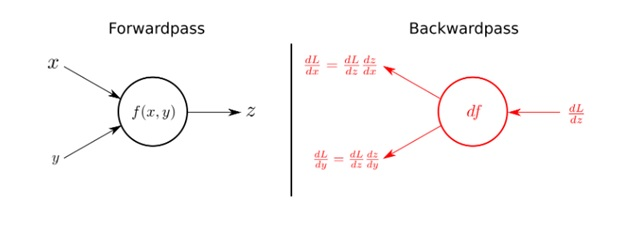

For example:
Z1 = W1* A0 +B1
A1=f(Z1)
=>
Z2=W2*A1+B2
A2=f(Z2)
...

and the process goes until reach the output layer with using activation function. and calculates loss.
As Activation function I use **Sigmoid Function** for hidden layers and I use **Softmax Function** for output layer.The reason I use the softmax function in the output layer is because there are more than 2 classes of data.

In multilayer perceptron each layer is feeding the next one with the result of their computation, their internal representation of the data. This goes all the way through the hidden layers to the output layer. But there is a problem. If the algorithm only computed one iteration, there would be no actual learning. Therefore,in this scenario a concept called backpropagation welcomes us.



**What is Backpropagation**

Backpropagation is the learning mechanism that allows the MLP to iteratively adjust the weights for minimizing the cost function.
For this purpose, the Gradient Descent optimization algorithm is used. This algorithm uses the first derivative to converge to the local minimum of the equation.

In each iteration, after the wighted sums are forwarded through all layers, the gradient of the Cross Entropy is computed across all input and output pairs.Then, to propagate it back, the weights of the first hidden layer are updated with the value of the gradient.That's how the weights are propagated back to the starting point of the neural network.




This process continues until the calculated gradient no longer changes or changes very little.



In [ ]:
import numpy as np
import math
import abc
from sklearn import datasets
from sklearn.model_selection import train_test_split 
from keras.datasets import mnist
import keras

Now we create a class named "Preprocessing". This class is used to prepare the dataset before it is used for training.

> ToCategoricalMatrix method is responsible for  turns a one-dimensional label set into a 2-dimensional array containing only 1s and 0s.

> NormalizeValues method  reduces the values ​​in the matrix between 0 and 1.




In [ ]:
class Preprocessing():
  def __init__(self): pass
  def ToCategoricalMatrix(self,x, nCol=None):
      if not nCol:
          nCol = np.amax(x) + 1
      cat = np.zeros((x.shape[0], nCol))
      cat[np.arange(x.shape[0]), x] = 1
      return cat
  def NormalizeValues(self,X):
    X /= 255
    return X

Now we create a class named "CrossEntropyLossFunction". This class is used for calculate error.

> loss method is responsible for  calculate loss.

> gradient methos id responsible for find gradient of loss



In [ ]:
class CrossEntropyLossFunction():
    def __init__(self): pass

    def loss(self, y, p,epsilon=1e-15):
        p = np.clip(p, epsilon, 1 - epsilon)
        return - y * np.log(p) - (1 - y) * np.log(1 - p)

    def gradient(self, y, p,epsilon=1e-15):
        p = np.clip(p, epsilon, 1 - epsilon)
        return - (y / p) + (1 - y) / (1 - p)

Now we create a class named "ActivationFunctions". This class is base class for Actvation Functions. I used 2 different activation functions for this problem.One of them is sigmoid. I used Sigmoid Function at hidden layers and i used Softmax Function at outputlayers. The reason i use softmax Function at output layer is there are more than 2 classes on dataset.Softmax is used for multi-classification in the model.




In [ ]:
class ActivationFunctions():
  @abc.abstractmethod
  def __call___(self,x):pass

  @abc.abstractmethod
  def Gradient(self,x):pass

class Softmax(ActivationFunctions):
    def __call__(self, x):
        s = np.max(x, axis=1)
        s = s[:, np.newaxis] 
        e_x = np.exp(x - s)
        div = np.sum(e_x, axis=1)
        div = div[:, np.newaxis] # dito
        return e_x / div

    def gradient(self, x):
        p = self.__call__(x)
        return p * (1 - p)

class Sigmoid(ActivationFunctions):
    def __call__(self, x):
        return 1 / (1 + np.exp(-x))

    def gradient(self, x):
        return self.__call__(x) * (1 - self.__call__(x))



Now we create a class named "MLP". MLP class has got 5 methods.


1.   InitializeWeightsAndBiasForLayers
2.   ForwardPropagation
3.   BackwardPropagation
4.   Fit
5.   Predict

Also in the constructor of this class, the number of hidden layers, number of iterations, learning rate, activation functions and loss functions are assigned.


InitializeWeightsAndBiasForLayers method generates first values for weights and bias values for features and hidden layers.

ForwardPropagation method takes 2 parameters(train_X,train_y) and calculates input values of hidden layers, output values of hidden layers, input values of output layer and prediction.And return these parameters.

BackwardPropagation method takes 3 parameters(train_X,train_y,parameters(which comes from ForwardProgapation function)). This function calculates the derivatives of the weights for the hidden layer and the out put layer and their bias values and returns this calculated weights and biases.

Fit method takes 2 parameters(train_X,train_y). This method has got a loop until reach iteration number and in that loop this function calls ForwardPropagation and BackwardPropagation to find new values for weights and biases and it calculates final weights and biases to use in Predict function.


Predict method takes single test data set.This function makes an estimate on this test dataset with the calculated weight and bias values and returns a prediction.



In [ ]:
class MLP():
    def __init__(self, nHidden, n_iterations=3000, learning_rate=0.01):
        self.nHidden = nHidden
        self.n_iterations = n_iterations
        self.learning_rate = learning_rate
        self.hiddenActivationFunction = Sigmoid()
        self.outputActivationFunction = Softmax()
        self.loss = CrossEntropyLossFunction()    

    def InitializeWeightsAndBiasForLayers(self, X, y):
        samplesCount, featuresCount = X.shape
        samplesOutputCount, outputsCount = y.shape
        self.W=np.random.randn(featuresCount,self.nHidden)*0.01
        self.W0=np.zeros((1,self.nHidden))
        self.V=np.random.randn(self.nHidden,outputsCount)*0.01
        self.V0=np.zeros((1,outputsCount))

    def ForwardPropagation(self,X,y):
      hiddenInput = X.dot(self.W) + self.W0
      hiddenOutput = self.hiddenActivationFunction(hiddenInput)

      outputLayerInput = hiddenOutput.dot(self.V) + self.V0
      pred = self.outputActivationFunction(outputLayerInput)  

      parameters = {"hiddenInput":hiddenInput,"hiddenOutput":hiddenOutput,"outputLayerInput":outputLayerInput,"pred":pred}
      return parameters
    def BackwardPropagation(self,X,y,parameters):

      pred,hiddenInput,hiddenOutput,outputLayerInput=parameters["pred"],parameters["hiddenInput"],parameters["hiddenOutput"],parameters["outputLayerInput"]

      gradOutputLayerInput = self.loss.gradient(y, pred) * self.outputActivationFunction.gradient(outputLayerInput)
      derV = hiddenOutput.T.dot(gradOutputLayerInput)
      derV0 = np.sum(gradOutputLayerInput, axis=0, keepdims=True)

      gradHiddenLayerInput = gradOutputLayerInput.dot(self.V.T) * self.hiddenActivationFunction.gradient(hiddenInput)
      derW = X.T.dot(gradHiddenLayerInput)
      derW0 = np.sum(gradHiddenLayerInput, axis=0, keepdims=True)

      params={"derW":derW,"derW0":derW0,"derV":derV,"derV0":derV0}
      return params

    def Fit(self, X, y):

        self.InitializeWeightsAndBiasForLayers(X, y)

        for i in range(self.n_iterations):
            parameters = self.ForwardPropagation(X,y)
            params=self.BackwardPropagation(X,y,parameters)
            derW,derW0,derV,derV0=params["derW"],params["derW0"],params["derV"],params["derV0"]
            self.V  -= self.learning_rate * derV
            self.V0 -= self.learning_rate * derV0
            self.W  -= self.learning_rate * derW
            self.W0 -= self.learning_rate * derW0
    
    def Predict(self, X):
        hiddenInput = X.dot(self.W) + self.W0
        hiddenOutput = self.hiddenActivationFunction(hiddenInput)

        outputLayerInput = hiddenOutput.dot(self.V) + self.V0
        prediction = self.outputActivationFunction(outputLayerInput)

        return prediction

**Now let's get our dataset and preprocess it.**

In [ ]:
from keras.datasets import mnist
import keras

(train_X, train_y), (test_X, test_y) = mnist.load_data()

train_X=train_X.reshape(train_X.shape[0],784).astype('float32')
test_X=test_X.reshape(test_X.shape[0],784).astype('float32')

pr=Preprocessing()
train_y=pr.ToCategoricalMatrix(train_y)
test_y=pr.ToCategoricalMatrix(test_y)
train_X = pr.NormalizeValues(train_X)
test_X = pr.NormalizeValues(test_X)



11490434/11490434 [==============================] - 1s 0us/step


**Now let's run our model with different settings.**

In [ ]:
clf = MLP(nHidden=1, n_iterations=1000, learning_rate=0.0001)
clf.Fit(train_X, train_y)

y_pred = np.argmax(clf.Predict(test_X), axis=1)

y_test = np.argmax(test_y, axis=1)
accuracy = np.sum(y_test == y_pred, axis=0)
accuracy = np.sum(y_test == y_pred, axis=0) / len(y_test)
print ("Accuracy:", accuracy)

In [ ]:
clf = MLP(nHidden=5, n_iterations=1000, learning_rate=0.0001)
clf.Fit(train_X, train_y)

y_pred = np.argmax(clf.Predict(test_X), axis=1)

y_test = np.argmax(test_y, axis=1)
accuracy = np.sum(y_test == y_pred, axis=0)
accuracy = np.sum(y_test == y_pred, axis=0) / len(y_test)
print ("Accuracy:", accuracy)

In [ ]:
clf = MLP(nHidden=10, n_iterations=1000, learning_rate=0.0001)
clf.Fit(train_X, train_y)

y_pred = np.argmax(clf.Predict(test_X), axis=1)

y_test = np.argmax(test_y, axis=1)
accuracy = np.sum(y_test == y_pred, axis=0)
accuracy = np.sum(y_test == y_pred, axis=0) / len(y_test)
print ("Accuracy:", accuracy)

In [ ]:
clf = MLP(nHidden=20, n_iterations=1000, learning_rate=0.0001)
clf.Fit(train_X, train_y)

y_pred = np.argmax(clf.Predict(test_X), axis=1)

y_test = np.argmax(test_y, axis=1)
accuracy = np.sum(y_test == y_pred, axis=0)
accuracy = np.sum(y_test == y_pred, axis=0) / len(y_test)
print ("Accuracy:", accuracy)

As can be seen, the success rate of the model varies in different settings. As the number of hidden layers increases, the success of the model increases.